<a href="https://colab.research.google.com/github/Khuzamaalk/T5_BootCamp/blob/main/Copy_of_Time_Series_Forecasting_Practical_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Forecasting Exam

In this exam, you will work on a time series forecasting task. The goal is to go through the entire workflow from loading the data to evaluating the model and making predictions. Follow each step carefully. The dataset is stored in you can access it [here](https://www.kaggle.com/datasets/khaledzsa/traffic-dataset), the target is to predict `traffic_volume` column. There is also command to download the dataset below.

## Dataset: Traffic Dataset

### Dataset Overview:

- **Name**: Traffic Dataset
- **Description**: This dataset contains hourly data on the traffic volume for westbound I-94, a major interstate highway in the US that connects Minneapolis and St Paul, Minnesota. The data was collected by the Minnesota Department of Transportation (MnDOT) from 2012 to 2018 at a station roughly midway between the two cities.
- **Time Period**: Starting from 18-11-2016
- **Frequency**: Hourly observations

### Features:

1. **temp:** a numeric variable that shows the average temperature in kelvin.
2. **rain_1h:** a numeric variable that shows the amount of rain in mm that occurred in the hour.
3. **snow_1h:** a numeric variable that shows the amount of snow in mm that occurred in the hour.
4. **clouds_all:** a numeric variable that shows the percentage of cloud cover.
5. **weather_main:** a categorical variable that gives a short textual description of the current weather (such as Clear, Clouds, Rain, etc.).
6. **weather_description:** a categorical variable that gives a longer textual description of the current weather (such as light rain, overcast clouds, etc.).
7. **date_time:** a datetime variable that shows the hour of the data collected in local CST time.
8. **traffic_volume:** a numeric variable that shows the hourly I-94 reported westbound traffic volume.

#### Feel free to add or rearrange steps as you see fit to optimize your workflow. One additional note: the model's performance doesn't need to be 100% accurate. Instead, focus on achieving the best possible results while balancing performance and generalization.

## Load the Data

Load the time series dataset into a pandas DataFrame.

**Instructions:**
- Use `pandas` to load your dataset.
- Display the first few rows to understand its structure.
- Make sure the datetime column is correctly parsed.

In [1]:
# Here is a helping code that will download and unzip the dataset for you.
# Once you download the dataset you may comment the code!
!kaggle datasets download -d khaledzsa/traffic-dataset
!unzip traffic-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/khaledzsa/traffic-dataset
License(s): unknown
100% 235k/235k [00:00<00:00, 409kB/s]
100% 235k/235k [00:00<00:00, 409kB/s]
Archive:  traffic-dataset.zip
  inflating: Traffic Data.csv        


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error
import math
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('/content/Traffic Data.csv', index_col='date_time', parse_dates=True)
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description
date_time,,,,,,,
2017-08-27 01:00:00,1209.0,291.15,0.0,0.0,90,Mist,mist
2018-09-06 23:00:00,1248.0,286.01,0.0,0.0,1,Clear,sky is clear
2017-08-25 18:00:00,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds
2017-11-09 22:00:00,2838.0,262.35,0.0,0.0,1,Clear,sky is clear
2017-11-09 15:00:00,5794.0,267.08,0.0,0.0,5,Clear,sky is clear


## Exploratory Data Analysis (EDA)

Perform exploratory data analysis on the dataset.

**Instructions:**
- Plot the time series data.
- Analyze trends, seasonality, and potential outliers.
- Plot boxplots or scatter plots to identify any outliers or anomalies in the data.
- Seasonal Decomposition: Use `seasonal_decompose` from the `statsmodels` library to break down the time series data into trend, seasonality, and residual components. Analyze each component to gain insights into the long-term movement (trend), regular patterns (seasonality), and remaining fluctuations (residuals).

Do more if needed!

In [4]:
df.shape

(20000, 7)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20000 entries, 2017-08-27 01:00:00 to 2018-05-31 18:00:00
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   traffic_volume       19980 non-null  float64
 1   temp                 20000 non-null  float64
 2   rain_1h              20000 non-null  float64
 3   snow_1h              20000 non-null  float64
 4   clouds_all           20000 non-null  int64  
 5   weather_main         20000 non-null  object 
 6   weather_description  20000 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 1.2+ MB


In [6]:
df.describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all
count,19980.000000,20000.000000,20000.000000,20000.0,20000.000000
mean,3278.186887,281.162680,0.048396,0.0,49.384600
std,1977.171357,12.661288,0.398007,0.0,39.647341
min,113.000000,243.390000,0.000000,0.0,0.000000
25%,1228.750000,271.950000,0.000000,0.0,1.000000
50%,3430.000000,281.825000,0.000000,0.0,75.000000
75%,4928.000000,291.840000,0.000000,0.0,90.000000
max,16781.000000,310.070000,10.600000,0.0,92.000000


In [7]:
df.duplicated().sum() # Not that much to remove

18

In [8]:
df.isnull().sum()

,0
traffic_volume,20
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0


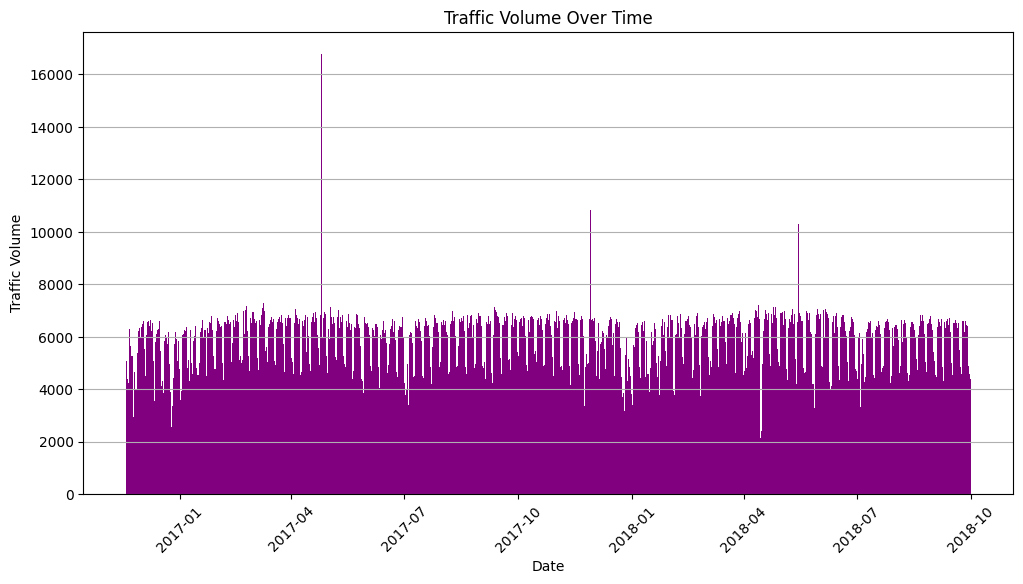

In [9]:
# 1) Plot time series data

plt.figure(figsize=(12, 6))
plt.bar(df.index, df['traffic_volume'], color='purple')
plt.title('Traffic Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

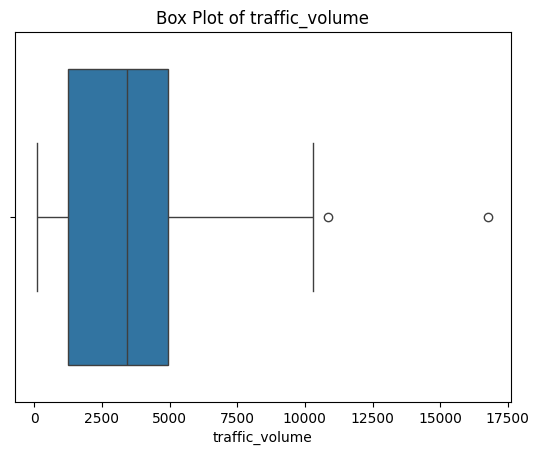

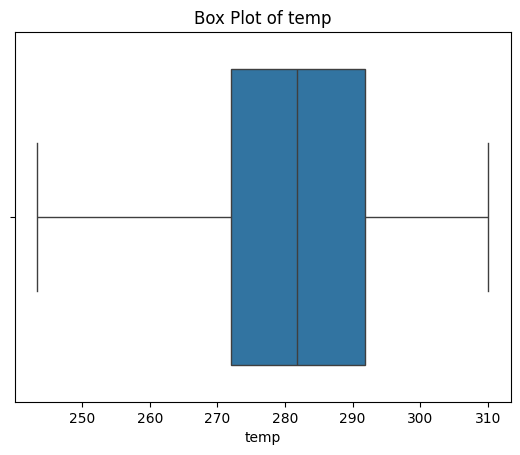

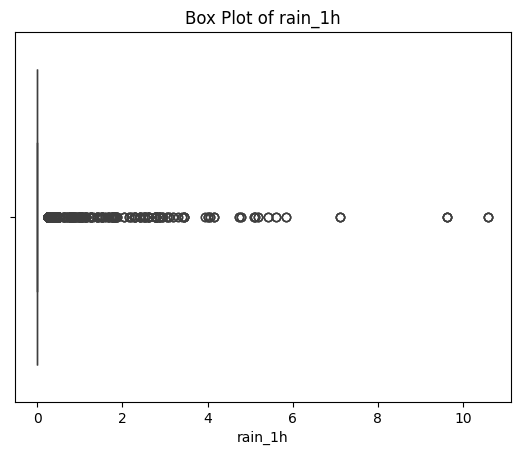

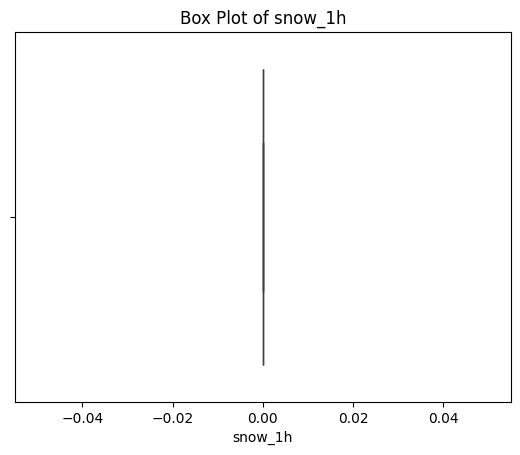

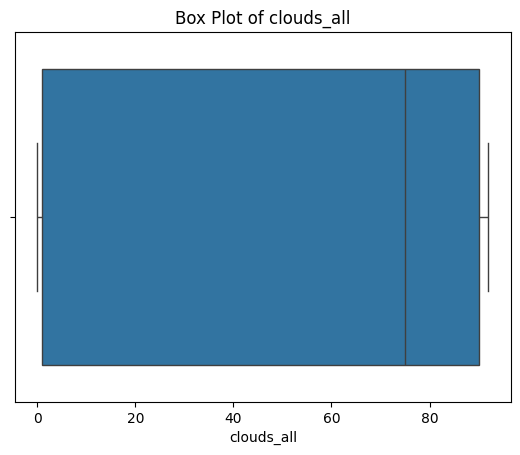

In [10]:
# 2) Outlier Detection

numerical_cols = df.select_dtypes(include=['float', 'int']).columns
for col in numerical_cols:
    plt.figure()
    # Reset the index, bcz it gives me "ValueError: cannot reindex on an axis with duplicate labels" so I did it to ensure unique labels for the boxplot and even for further analysis.
    sns.boxplot(x=df.reset_index(drop=True)[col])
    plt.title(f'Box Plot of {col}')
    plt.show()

## Data Preprocessing

Clean and preprocess the data.

**Instructions:**
- Handle any missing values in the dataset.
- If necessary, resample the data to ensure consistent time intervals.
- Create any additional features needed, such as lags or moving averages.
- Make sure that the dates are sorted correctly.

Do more if needed!

In [11]:
# I took a samole for the column with missing values before dropping

df['traffic_volume'].sample(5)

,traffic_volume
date_time,
2017-01-17 20:00:00,2491.0
2018-09-14 17:00:00,5358.0
2018-01-13 18:00:00,3141.0
2017-02-21 23:00:00,1169.0
2017-11-14 09:00:00,5531.0


In [12]:
# 1) Fill missing values with -Mean- for column with no outliers

df['traffic_volume'].fillna(df['traffic_volume'].mean(), inplace=True)

In [13]:
df.isnull().sum() # Check if there are any missing values left

,0
traffic_volume,0
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0


In [14]:
# 2) Remove the outliers with the IQR method

for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

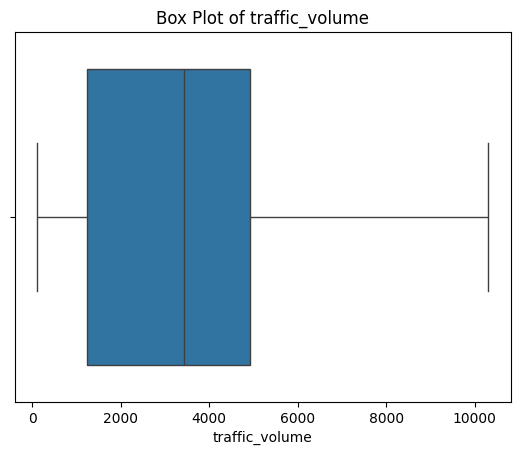

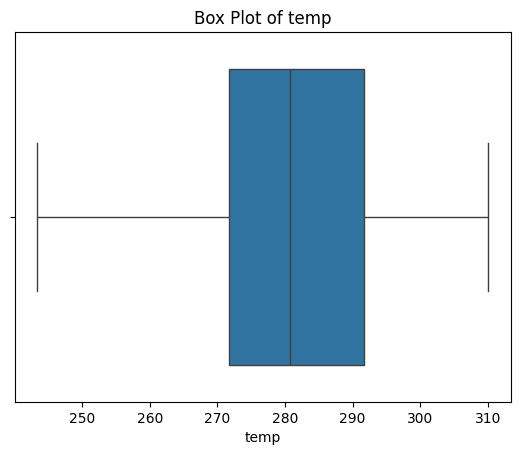

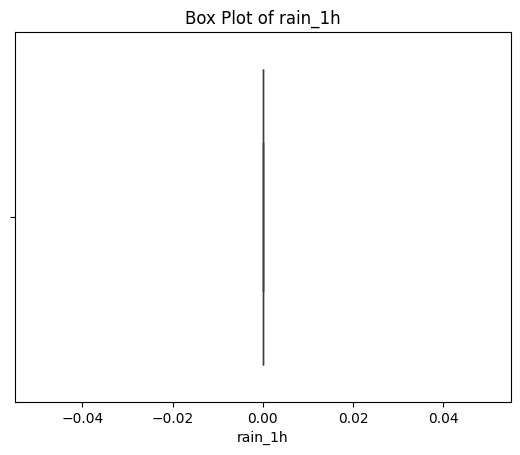

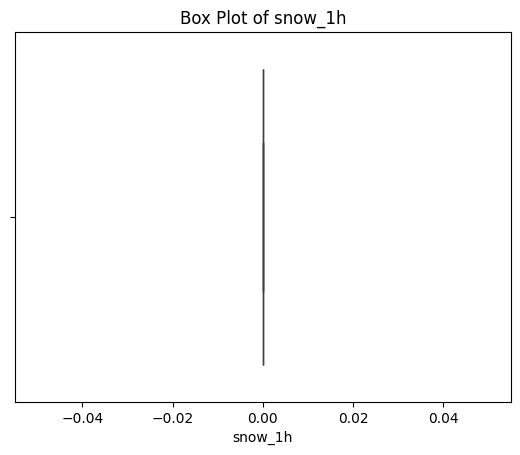

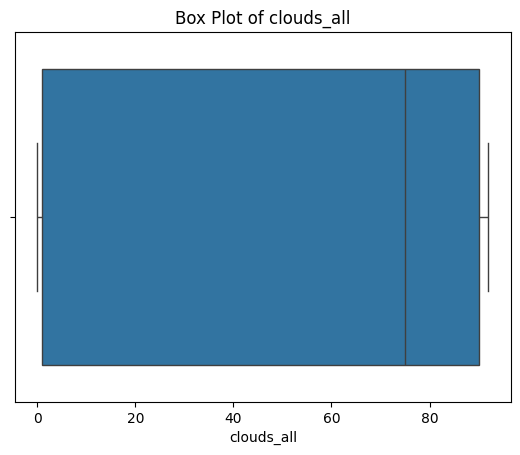

In [15]:
# 3) Check if there are any outliers left

numerical_cols = df.select_dtypes(include=['float', 'int']).columns
for col in numerical_cols:
    plt.figure()
    sns.boxplot(x=df[col])
    plt.title(f'Box Plot of {col}')
    plt.show()

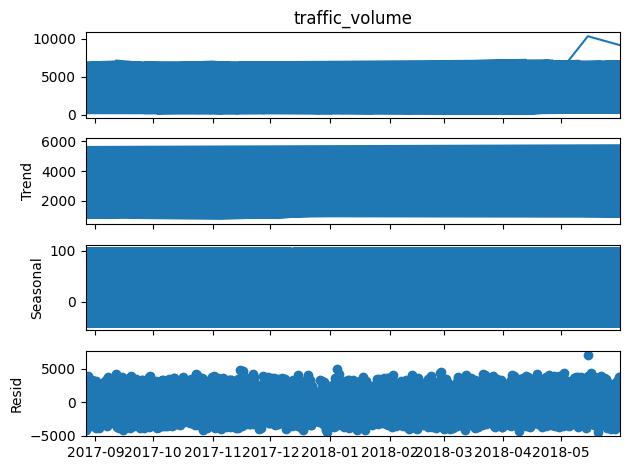

In [16]:
# 4) Now we can apply the seasonal decomposition after removing the missing values

# period=7 -> indicating a weekly pattern in the data

result = seasonal_decompose(df['traffic_volume'], model='additive', period=7)
result.plot()
plt.show()

## Feature Engineering

### Instructions:
  
- **Shift Method**: Use the `shift` method to create a new column `prev_traffic_volume`, which represents the previous day's traffic volume.

- **Difference between traffic_volume**: Calculate the difference between the values in `traffic_volume` column to highlight short-term volume.

- **Date Features**: Extract meaningful time-based features from the `date_time` column to enhance the model's ability to detect temporal patterns. These features include:
  - **Day of the week**: To capture weekly seasonality.
  - **Month**: To capture monthly trends.
  - **Day of the year**: Useful for modeling yearly seasonality.


In [53]:
# 1) Create 'lag' prev_traffic_volume using shift, to represent the previous day's traffic volume

df['prev_traffic_volume'] = df['traffic_volume'].shift(1)

In [54]:
df = df.reindex(columns=['traffic_volume', 'prev_traffic_volume'])
df.head()

,traffic_volume,prev_traffic_volume
date_time,,
2017-08-27 01:00:00,1209.0,NaN
2018-09-06 23:00:00,1248.0,1209.0
2017-08-25 18:00:00,4602.0,1248.0
2017-11-09 22:00:00,2838.0,4602.0
2017-11-09 15:00:00,5794.0,2838.0


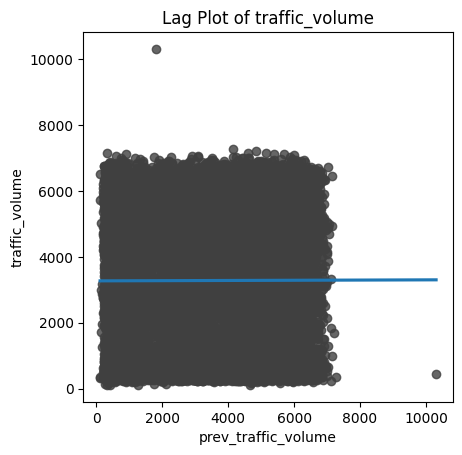

In [49]:
fig, ax = plt.subplots()
ax = sns.regplot(x='prev_traffic_volume', y='traffic_volume', data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of traffic_volume');

In [51]:
# 2) Calculate the difference between the values in traffic_volume column

df['diff_traffic_volume'] = df['traffic_volume'].diff()

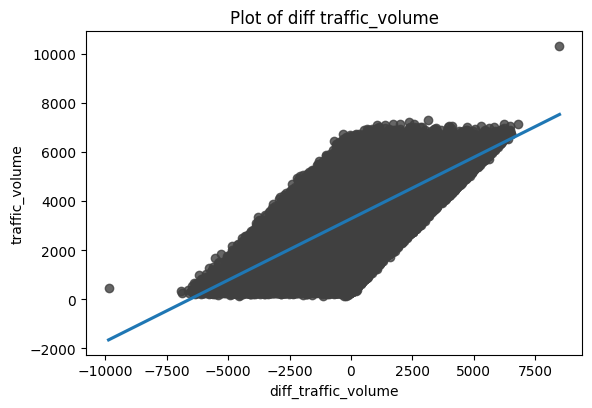

In [52]:
fig, ax = plt.subplots()
ax = sns.regplot(x='diff_traffic_volume', y='traffic_volume', data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Plot of diff traffic_volume');

In [20]:
# 3) Extract meaningful time-based features

df['Day_of_Week'] = df.index.dayofweek # This library rely on international standards: Monday=0, Sunday=6
df['Month'] = df.index.month
df['Day_of_Year'] = df.index.dayofyear

In [21]:
df['Day_of_Week'].sample(5)

,Day_of_Week
date_time,
2017-01-22 20:00:00,6
2018-07-06 10:00:00,4
2016-11-28 04:00:00,0
2017-11-06 02:00:00,0
2016-11-22 02:00:00,1


In [22]:
df['Month'].sample(5)

,Month
date_time,
2016-11-30 15:00:00,11
2018-09-14 14:00:00,9
2016-12-11 03:00:00,12
2017-09-12 10:00:00,9
2017-09-20 03:00:00,9


In [23]:
df['Day_of_Year'].sample(5)

,Day_of_Year
date_time,
2017-04-29 15:00:00,119
2017-11-03 18:00:00,307
2018-06-09 13:00:00,160
2017-04-06 00:00:00,96
2016-12-17 08:00:00,352


## Feature Scaling

Apply feature scaling to the data if needed.

**Instructions:**
- Use a scaling method such as MinMaxScaler or StandardScaler.
- Ensure scaling is applied correctly to both training and testing data.

In [68]:
scaler = MinMaxScaler()

scaled_data=scaler.fit_transform(np.array(df).reshape(-1,1))

## Train-Test Split

Split the dataset into training and testing sets.

**Instructions:**
- Ensure the split maintains the time order of the data.
- Decide on an appropriate ratio for splitting the data.

In [70]:
# 1) Split into train - test

train_size = int(len(df) * 0.8)  # 80% training
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

In [71]:
# 2) Display the sizes of the training and testing sets

print("Training Set Size:", train_data.shape)
print("Testing Set Size:", test_data.shape)

Training Set Size: (15428, 2)
Testing Set Size: (3857, 2)


## Models Selection

Choose two models for time series forecasting.

**Instructions:**
- Select two models such as ARIMA, SARIMA, RNN, LSTM, or GRU.
- Train these models and then compare their performance.

In [72]:
n_past = 60

# Prepare sequences for RNN & LSTM for the train set
X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_scaled[i - n_past:i, 0])
    y_train.append(train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Similarly prepare sequences for the test set
X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_scaled[i - n_past:i, 0])
    y_test.append(test_scaled[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

In [73]:
# Reshape input data for RNN & LSTM ([samples, sequence, features])
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

### Model 1 Training

Train your first model on the training dataset.

**Instructions:**
- Fit the first model to the training data.
- Ensure to monitor the training process.

In [74]:
rnn_model = Sequential()
rnn_model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
rnn_model.add(Dropout(0.2)) #to prevent overfitting
rnn_model.add(SimpleRNN(units=50, return_sequences=True))
rnn_model.add(Dropout(0.2))
rnn_model.add(SimpleRNN(units=50))
rnn_model.add(Dropout(0.2))
rnn_model.add(Dense(units=1))
rnn_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_6 (SimpleRNN)             │ (None, 60, 50)              │           2,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_7 (SimpleRNN)             │ (None, 60, 50)              │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_8 (SimpleRNN)             │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,751 (49.81 KB)

 Trainable params: 12,751 (49.81 KB)

 Non-trainable params: 0 (0.00 B)

In [75]:
rnn_model.compile(loss='mean_squared_error',optimizer='adam') # using the (MSE) bcz it's regression 'Prediction'

In [85]:
# Training RNN model
history = rnn_model.fit(X_train, y_train,
          validation_data=(X_test,y_test),
          epochs=10,
          batch_size=32,
          verbose=1,)

Epoch 1/10
481/481 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0382 - val_loss: 0.0379
Epoch 2/10
481/481 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0381 - val_loss: 0.0373
Epoch 3/10
481/481 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0372 - val_loss: 0.0371
Epoch 4/10
481/481 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0381 - val_loss: 0.0372
Epoch 5/10
481/481 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0377 - val_loss: 0.0371
Epoch 6/10
481/481 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0374 - val_loss: 0.0373
Epoch 7/10
481/481 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0378 - val_loss: 0.0373
Epoch 8/10
481/481 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.0378 - val_loss: 0.0371
Epoch 9/10
481/481 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0373 - val_loss: 0.0371
Epoch 10/10
481/481 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 0.0373 - val_loss: 0.0372


### Make 1 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [86]:
rnn_train_predict=rnn_model.predict(X_train)
rnn_test_predict=rnn_model.predict(X_test)

481/481 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


### Model 1 Evaluation

Evaluate the performance of your first model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [87]:
rnn_train_predict = scaler.inverse_transform(rnn_train_predict)
rnn_test_predict = scaler.inverse_transform(rnn_test_predict)

In [88]:
# Calculate train data RMSE
print(math.sqrt(mean_squared_error(y_train,rnn_train_predict)))
# Calculate test data RMSE
print(math.sqrt(mean_squared_error(y_test,rnn_test_predict)))

3212.608156534085
3211.5904695750082


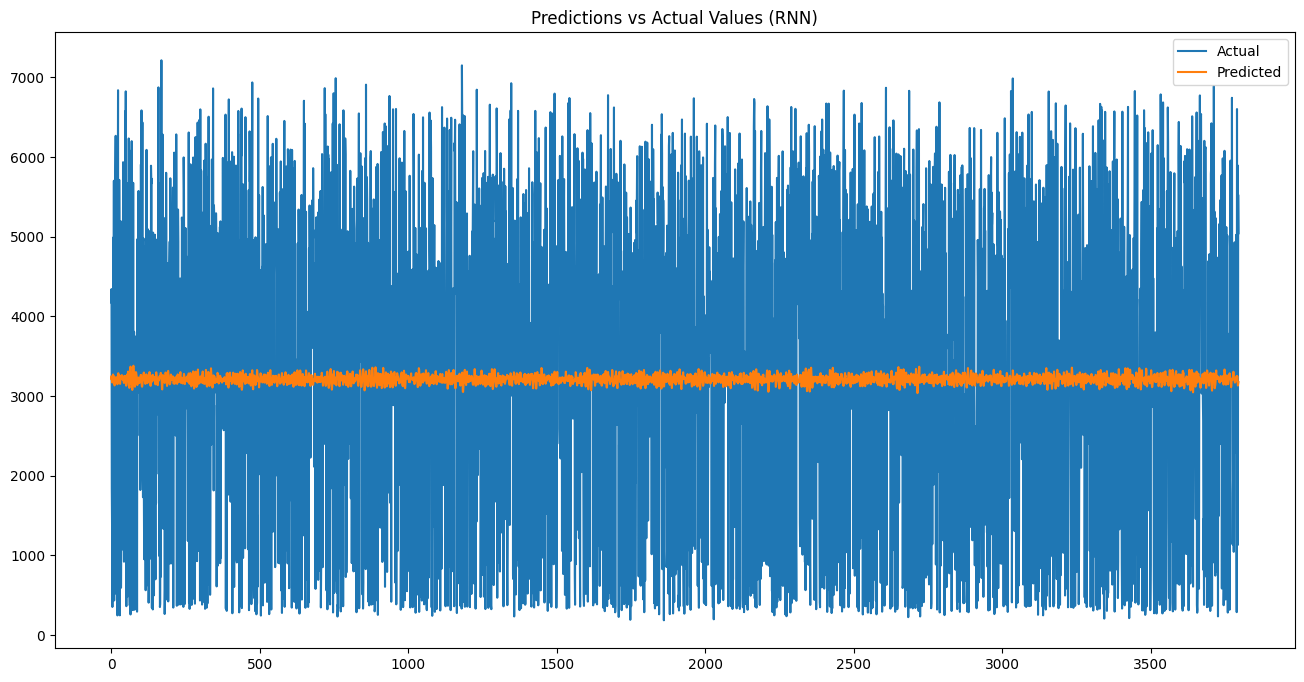

In [89]:
plt.figure(figsize=(16,8))
plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)), label="Actual")
plt.plot(rnn_test_predict, label="Predicted")
plt.legend()
plt.title("Predictions vs Actual Values (RNN)")
plt.show()

In [90]:
training_loss = rnn_model.history.history['loss']
validation_loss = rnn_model.history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, validation_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

KeyError: 'loss'

### Model 2 Training

Train your second model on the training dataset.

**Instructions:**
- Fit the second model to the training data.
- Ensure to monitor the training process.

In [92]:
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=50, return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units=1))
lstm_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 60, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [93]:
lstm_model.compile(loss='mean_squared_error',optimizer='adam')

In [94]:
# Training our LSTM model
history = lstm_model.fit(X_train, y_train,
          validation_data=(X_test,y_test),
          epochs=10,
          batch_size=32,
          verbose=1,)

Epoch 1/10
481/481 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.0422 - val_loss: 0.0372
Epoch 2/10
481/481 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0384 - val_loss: 0.0373
Epoch 3/10
481/481 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0381 - val_loss: 0.0375
Epoch 4/10
481/481 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0385 - val_loss: 0.0371
Epoch 5/10
481/481 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0373 - val_loss: 0.0375
Epoch 6/10
481/481 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0380 - val_loss: 0.0371
Epoch 7/10
481/481 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0383 - val_loss: 0.0371
Epoch 8/10
481/481 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.0383 - val_loss: 0.0374
Epoch 9/10
481/481 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0381 - val_loss: 0.0371
Epoch 10/10
481/481 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0373 - val_loss: 0.0372


### Make 2 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [96]:
lstm_train_predict=lstm_model.predict(X_train)
lstm_test_predict=lstm_model.predict(X_test)

481/481 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


### Model 2 Evaluation

Evaluate the performance of your second model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [97]:
lstm_train_predict = scaler.inverse_transform(lstm_train_predict)
lstm_test_predict = scaler.inverse_transform(lstm_test_predict)

In [98]:
# Calculate train data RMSE
print(math.sqrt(mean_squared_error(y_train,lstm_train_predict)))
# Calculate test data RMSE
print(math.sqrt(mean_squared_error(y_test,lstm_test_predict)))

3470.5131928318237
3470.9105583287815


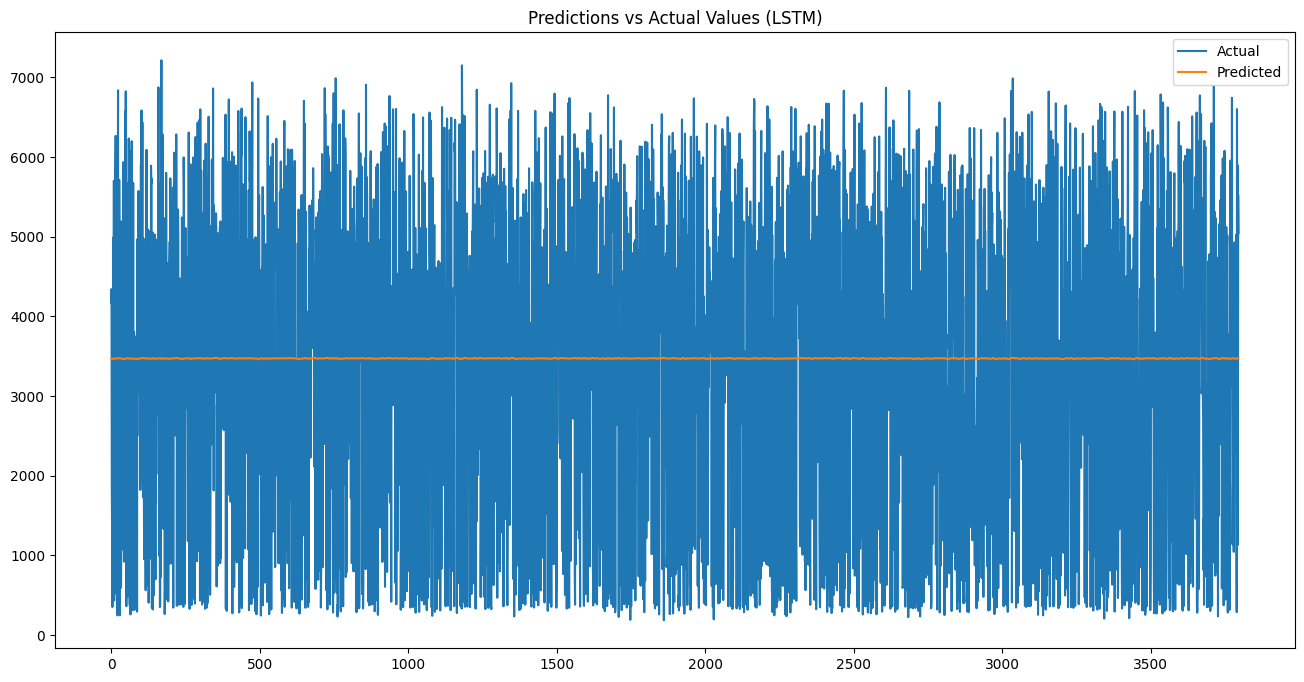

In [99]:
plt.figure(figsize=(16,8))
plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)), label="Actual")
plt.plot(lstm_test_predict, label="Predicted")
plt.legend()
plt.title("Predictions vs Actual Values (LSTM)")
plt.show()

In [103]:
training_loss = lstm_model.history.history['loss']
validation_loss = lstm_model.history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, validation_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

KeyError: 'loss'

## Project Questions:

1. **Data Preprocessing**: Explain why you chose your specific data preprocessing techniques (e.g., normalization, handling missing values). How did these techniques help prepare the data for training the model?
2. **Feature Engineering**: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the forecasting model.
3. **Model Architecture**: Describe the reasoning behind your model’s architecture (e.g., the type of model, layers, number of neurons, and activation functions). Why did you believe this architecture was appropriate for time series forecasting?
4. **Training Process**: Discuss why you chose your batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you experiment with different values, and what were the outcomes?
5. **Loss Function and Metrics**: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the objective of forecasting?
6. **Model Tuning (If Done)**: Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve model performance?
7. **Overfitting and Underfitting**: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues?
8. **Future Improvements**: Suggest potential improvements or further steps you could take to enhance model performance. Consider using different algorithms, feature engineering techniques, or tuning hyperparameters.

### Answer Here: